In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
def build_model(my_learning_rate, inputs, outputs):
  model = tf.keras.Model(inputs = inputs, outputs= outputs)
  model.compile(optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate= my_learning_rate),
                loss= "mean_absolute_error",
                metrics = tf.keras.metrics.RootMeanSquaredError())
  return model

def train_model(model, df, label_name, epochs, batch_size):
  feature = {name:np.array(value) for name, value in df.items()}
  label = np.array(feature.pop(label_name))

  history = model.fit(x= feature, y = label, epochs= epochs, batch_size= batch_size)

  epochs = history.epoch

  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return hist, epochs, rmse

In [5]:
train_df = pd.read_csv("/content/sample_data/california_housing_train.csv")
test_df = pd.read_csv("/content/sample_data/california_housing_test.csv")

train_df = train_df.reindex(np.random.permutation(train_df.index))

scale_factor = 1000
train_df /= scale_factor

In [ ]:
learning_rate = 0.1
epochs = 35
batch_size = 10
feature = "total_rooms"
label = "median_house_value"

model = build_model(my_learning_rate= learning_rate)
hist , epochs, mae = train_model(model = model, df = train_df, feature=feature, label=label, epochs=epochs, batch_size=batch_size)

In [ ]:
hist

In [6]:
def plot_the_loss_curve(epochs, rmse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

In [ ]:
plot_the_loss_curve(epochs, mae)

In [7]:
input={
    "latitude": tf.keras.layers.Input(shape= (1,), dtype= tf.float32, name="Latitude"),
    "longitude":tf.keras.layers.Input(shape= (1,), dtype= tf.float32, name= "Longitude")
}

In [15]:
resolution_degree = 1.0

latitude_boundaries = list(np.arange(int(min(train_df["latitude"])),
                                     int(max(train_df["latitude"])),
                                     resolution_degree))

latitude = tf.keras.layers.Discretization(
    bin_boundaries= latitude_boundaries,
    name = "Discretization_LatitudeLayer"
)(input.get("latitude"))

latitude = tf.keras.layers.CategoryEncoding(
    num_tokens= len(latitude_boundaries) + 1,
    output_mode = "one_hot",
    name= "Latitude_CategoryEncoding_Layer"
)(latitude)


longitude_boundaries = list(np.arange(
    int(min(train_df["longitude"])),
    int(max(train_df["longitude"])),
    resolution_degree
    ))

longitude = tf.keras.layers.Discretization(
    bin_boundaries = longitude_boundaries,
    name = "Discreatization_LongitudeLayer"
)(input.get("longitude"))

longitude = tf.keras.layers.CategoryEncoding(
    num_tokens = len(longitude_boundaries) + 1,
    output_mode = "one_hot",
    name= "Longitude_CategoryEncoding_Layer"
)(longitude)

Concatenate = tf.keras.layers.Concatenate()([latitude, longitude])
dense_output = tf.keras.layers.Dense(units = 1, name= "Dense_Output")(Concatenate)

output = {
    "Output": dense_output
}

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1700/1700 [==============================] - 7s 3ms/step - loss: 103.8112 - root_mean_squared_error: 140.4699
Epoch 2/35
1700/1700 [==============================] - 3s 2ms/step - loss: 88.8483 - root_mean_squared_error: 119.0765
Epoch 3/35
1700/1700 [==============================] - 3s 2ms/step - loss: 88.8283 - root_mean_squared_error: 119.1283
Epoch 4/35
1700/1700 [==============================] - 4s 2ms/step - loss: 88.8344 - root_mean_squared_error: 118.9504
Epoch 5/35
1700/1700 [==============================] - 3s 2ms/step - loss: 88.8440 - root_mean_squared_error: 119.1863
Epoch 6/35
1700/1700 [==============================] - 3s 2ms/step - loss: 88.8219 - root_mean_squared_error: 119.1666
Epoch 7/35
1700/1700 [==============================] - 4s 2ms/step - loss: 88.8454 - root_mean_squared_error: 119.0497
Epoch 8/35
1700/1700 [==============================] - 4s 2ms/step - loss: 88.8295 - root_mean_squared_error: 119.1271
Epoch 9/35
1700/1700 [============================

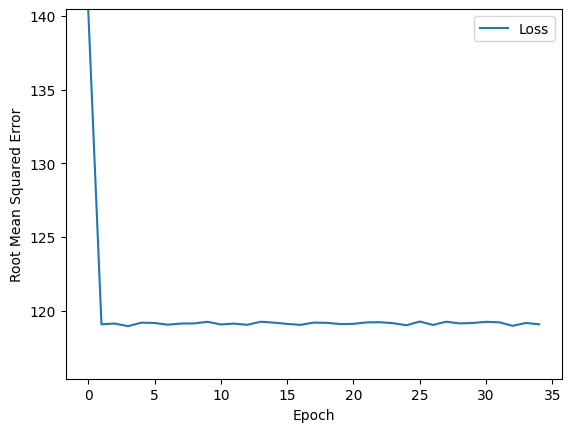

In [16]:
learning_rate = 0.1
epochs = 35
batch_size = 10
label_name = "median_house_value"

model = build_model(learning_rate, input, output)
hist, epochs, rmse = train_model(model, train_df, label_name, epochs, batch_size)
plot_the_loss_curve(epochs, rmse)

In [21]:
test_features = {name:np.array(values) for name, values in test_df.items()}
test_label = np.array(test_features.pop(label_name))
model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

 31/300 [==>...........................] - ETA: 0s - loss: 197935.5469 - root_mean_squared_error: 225161.9375  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


300/300 [==============================] - 1s 2ms/step - loss: 205667.2656 - root_mean_squared_error: 234714.3750


[205667.265625, 234714.375]